In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

In [3]:
y_cat_test = to_categorical(y_test,num_classes=10)
y_cat_train = to_categorical(y_train,num_classes=10)

In [4]:
x_train = X_train/255
x_test = X_test/255

In [5]:
import keras
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [22]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

def build_mnist_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))

    for i in range(hp.Int('num_layers', 2, 8)):
        model.add(keras.layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),activation='relu'))

    model.add(keras.layers.Dense(10, activation='softmax'))
    
    
    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log')
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    batch_size = hp.Choice('batch_size', values=[32,64,96,128])
    num_epochs = hp.Int('epochs', min_value=5, max_value=35, step=5)
    
    return model

In [23]:
tuner = kt.RandomSearch(build_mnist_model,
                        objective='val_accuracy',
                        max_trials=10,
                        executions_per_trial=2,
                        directory='mnist_hrd_tuning_3',
                        project_name='mnist_hrd_model_tuning')

Reloading Tuner from mnist_hrd_tuning_3\mnist_hrd_model_tuning\tuner0.json


In [24]:
tuner.search(x_train, y_cat_train,validation_data=(x_test, y_cat_test),epochs=25)

Trial 10 Complete [00h 04m 54s]
val_accuracy: 0.969400018453598

Best val_accuracy So Far: 0.9827499985694885
Total elapsed time: 00h 42m 08s


In [25]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of layers: {best_hps.get('num_layers')}")
print(f"Best units per layer: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print("Best batch size:", best_hps.get('batch_size'))

Best number of layers: 5
Best units per layer: [160, 256, 160, 256, 64]
Best learning rate: 0.0007654816567908454
Best batch size: 64


In [33]:
print("Best epochs:", best_hps.get('epochs'))

Best epochs: 5


In [26]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_cat_train,epochs=25,validation_data=(x_test, y_cat_test))

Epoch 1/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2392 - accuracy: 0.9273 - val_loss: 0.1386 - val_accuracy: 0.9574
Epoch 2/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1058 - accuracy: 0.9676 - val_loss: 0.1202 - val_accuracy: 0.9656
Epoch 3/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0779 - accuracy: 0.9762 - val_loss: 0.0979 - val_accuracy: 0.9707
Epoch 4/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0646 - accuracy: 0.9806 - val_loss: 0.0885 - val_accuracy: 0.9761
Epoch 5/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0521 - accuracy: 0.9845 - val_loss: 0.0837 - val_accuracy: 0.9766
Epoch 6/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0401 - accuracy: 0.9880 - val_loss: 0.1097 - val_accuracy: 0.9712
Epoch 7/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0373 - accuracy: 0.9890 - val_loss: 0.0831 - val_accuracy:

In [27]:
history.history

{'loss': [0.23921434581279755,
  0.10584308952093124,
  0.07790107280015945,
  0.06463032960891724,
  0.052073124796152115,
  0.040069498121738434,
  0.037268754094839096,
  0.032872915267944336,
  0.029740219935774803,
  0.026289092376828194,
  0.02454238571226597,
  0.022760238498449326,
  0.02117806486785412,
  0.01852506399154663,
  0.01865674927830696,
  0.015181872993707657,
  0.015957389026880264,
  0.015485127456486225,
  0.01583845354616642,
  0.01296500489115715,
  0.012343519367277622,
  0.01594306342303753,
  0.012983872555196285,
  0.011691424995660782,
  0.011142841540277004],
 'accuracy': [0.9273166656494141,
  0.9676499962806702,
  0.9761999845504761,
  0.9805999994277954,
  0.9844833612442017,
  0.9879999756813049,
  0.9889833331108093,
  0.9899333119392395,
  0.991100013256073,
  0.9922833442687988,
  0.9923666715621948,
  0.9931166768074036,
  0.9938333630561829,
  0.994949996471405,
  0.9945499897003174,
  0.9954500198364258,
  0.9952999949455261,
  0.99550002813339

In [28]:
metrics = pd.DataFrame(history.history)

In [29]:
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.239214,0.927317,0.138605,0.9574
1,0.105843,0.967650,0.120243,0.9656
2,0.077901,0.976200,0.097933,0.9707
3,0.064630,0.980600,0.088516,0.9761
4,0.052073,0.984483,0.083734,0.9766
5,0.040069,0.988000,0.109693,0.9712
6,0.037269,0.988983,0.083150,0.9798
7,0.032873,0.989933,0.094168,0.9746
8,0.029740,0.991100,0.082434,0.9795
9,0.026289,0.992283,0.108673,0.9754


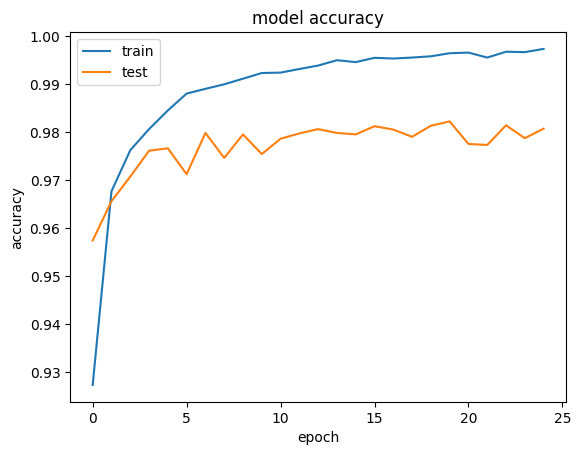

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

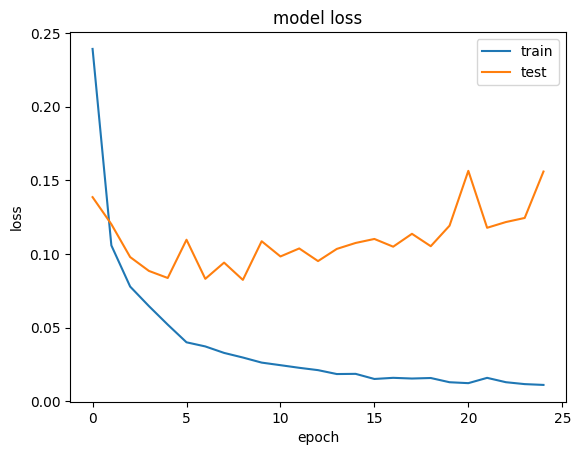

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

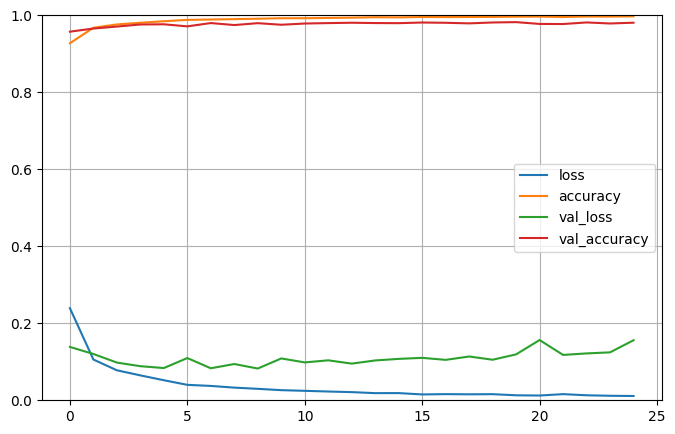

In [32]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 160)               125600    
                                                                 
 dense_4 (Dense)             (None, 256)               41216     
                                                                 
 dense_5 (Dense)             (None, 160)               41120     
                                                                 
 dense_6 (Dense)             (None, 256)               41216     
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 10)               